# Libraries

In [1]:
! pip install transformers
! pip install hazm
from hazm import *
import copy
import transformers
from transformers import AdamW
from transformers.optimization import get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score
import math
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import json
from copy import deepcopy
import numpy as np
import random
import re
import string
import codecs
from shutil import copyfile
random.seed(12345)
label_encoder = preprocessing.LabelEncoder()

# Loading & Preprocessing data

In [2]:
# downloading data
! gdown --id 1KpJCXTkuy1NLR5MgXsoYfBsv_OnwJqIF
# downloading persian stopwords
! gdown --id 1Qiq2I8EdTcgn2Wc03XqucUcMhBdVhEre

Downloading...
From: https://drive.google.com/uc?id=1KpJCXTkuy1NLR5MgXsoYfBsv_OnwJqIF
To: /content/AI_NEWS.csv
100% 16.8M/16.8M [00:00<00:00, 78.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Qiq2I8EdTcgn2Wc03XqucUcMhBdVhEre
To: /content/stopwords.txt
100% 3.66k/3.66k [00:00<00:00, 6.13MB/s]


In [3]:
news = pd.read_csv('AI_NEWS.csv')
news

,Unnamed: 0,index,title,text,category,keywords,source_name,data,tag
0,0,2000,لیگ قهرمانان آسیا| استقلال ایران 3 - الشرطه عر...,NaN,ورزشی,لیگ قهرمانان آسیا| استقلال ایران - الشرطه عراق...,جماران,1463620,غیر مهم
1,1,2001,سویه لامبدا؛ خیلی دور، خیلی نزدیک!/ هر آنچه که...,NaN,اقتصادی,NaN,آنا,3041187,غیر مهم
2,2,2002,افزایش تحرکات هیات ها در مذاکرات وین؛ تحولاتی ...,به گزارش خبرنگار ایرنا از وین، آهنگ رفت و آمد ...,بین الملل,"وین,کمیسیون مشترک برجام,علی باقری,مذاکرات برای...",ایرنا,4132788,مهم
3,3,2003,ناکارآمدی بازرگانی محصولات کشاورزی ناشی از ناک...,به گزارش خبرگزاری فارس از تبریز، اکبر فتحی در ...,اقتصادی,"کشاورزی,آذربایجان شرقی,کشاورزان,محصولات,کشت فر...",خبرگزاری فارس,3652101,غیر مهم
4,4,2004,طالبان: بدنبال روابط خوب با همه کشورها از جمله...,به گزارش دفتر منطقه ای خبرگزاری تسنیم، «ذبیح ا...,بین الملل,NaN,خبرگزاری تسنیم,3846298,غیر مهم
...,...,...,...,...,...,...,...,...,...
3995,3995,8972,درگیری شدید شبه نظامیان امارات و عربستان در اس...,به گزارش گروه بین الملل خبرگزاری تسنیم به نقل ...,بین الملل,NaN,خبرگزاری تسنیم,2263257,غیر مهم
3996,3996,8973,امام خمینی (ره) بیش از ایران در جهان موثر بود...,به گزارش خبرنگار خبرگزاری شبستان از شیراز، اند...,فرهنگ و هنر,NaN,شبستان,1967520,غیر مهم
3997,3997,8974,مادری که رهبر انقلاب برایش دعا کردند کیست؟/ قر...,گروه خانواده؛ نعیمه موحد: دیدار دانشجویی امسال...,فرهنگ و هنر,"حضرت آیت الله خامنه ای,جنبش دانشجویی,خبر خوب,...",خبرگزاری فارس,1748716,غیر مهم
3998,3998,8975,\t\t \t\t\tلحظه دلهره آور نجات سگی که در یخبن...,به گزارش خبرنگار حوزه اخبار داغ گروه فضای مجاز...,فناوری و ارتباطات,نجات سگ \t\t\t\t\t، \t\t\...,باشگاه خبرنگاران,61151,غیر مهم


In [4]:
class Preprocessing:

  @staticmethod
  def remove_punctuations(text):
    new_text = []
    for l in text:
      if l not in string.punctuation + '\u00AB' + '\u00BB' + '\u060C' + '\u061B' + '\u061F':
        new_text.append(l)
      else:
        new_text.append(' ')
    return ''.join(new_text)
  
  @staticmethod
  def remove_numbers(text):
    new_text = []
    for l in text:
      if l not in '0123456789۰۱۲۳۴۵۶۷۸۹':
        new_text.append(l)
      else:
        new_text.append(' ')
    return ''.join(new_text)

  @staticmethod
  def remove_stopwords(text):
    normalizer = Normalizer()
    stopwords = [normalizer.normalize(x.strip()) for x in codecs.open('stopwords.txt','r','utf-8').readlines()]
    tokens = word_tokenize(text)
    new_text = []
    for token in tokens:
      if token not in stopwords:
        new_text.append(token)
      else:
        new_text.append(' ')
    return ' '.join(new_text)

  @staticmethod
  def remove_extra_space(text):
    new_text = re.sub(r'\s+',' ',text)
    return new_text

In [5]:
# a class to hold our data structure
class Data:
  def __init__(self, data, preprocessing=False):
    self.title = data['title']
    self.text = data['text']
    self.keywords = data['keywords']
    self.category = data['category']
    self.label = label_encoder.transform([data['tag']])[0]

# label encoder
all_labels = ['مهم','غیر مهم']
label_encoder.fit(all_labels)
classes = label_encoder.classes_

# convert raw data into Data objects
news_data = []
for index, data in news.iterrows():
  news_data.append(Data(data, True))

In [6]:
def split_data(data, portions=[.6,.2,.2]):
  random.shuffle(data)
  data_len = len(data)
  train_data = data[:int(portions[0] * data_len)]
  eval_data = data[int(portions[0] * data_len):int((portions[0] + portions[1]) * data_len)]
  test_data = data[int((portions[0] + portions[1]) * data_len):]
  return train_data, eval_data, test_data

In [7]:
# a function to get a portion of data with acquired preprocessings
def get_data(dataset, preprocess={
    'remove_stopwords': True,
    'remove_punctuations': True,
    'remove_numbers': True}):
  random.shuffle(dataset)
  new_dataset = []

  # applying preprocessings on train data
  for i, data in enumerate(tqdm(dataset)):
    if str(data.text) == 'nan':
      continue
    if preprocess['remove_stopwords'] == True:
      dataset[i].text = Preprocessing.remove_stopwords(data.text)
    if preprocess['remove_punctuations'] == True:
      dataset[i].text = Preprocessing.remove_punctuations(data.text)
    if preprocess['remove_numbers'] == True:
      dataset[i].text = Preprocessing.remove_numbers(data.text)
    dataset[i].text = Preprocessing.remove_extra_space(data.text)
    new_dataset.append(dataset[i])

  return split_data(new_dataset)

# Roberta

In [8]:
train_data, eval_data, test_data = get_data(news_data, preprocess={
    'remove_stopwords': True,
    'remove_punctuations': True,
    'remove_numbers': True})

100%|██████████| 4000/4000 [01:21<00:00, 49.07it/s]


## Load Roberta

In [9]:
# loading pars roberta and tokenizer
from transformers import AutoConfig, AutoTokenizer, AutoModel, TFAutoModel
# v3.0
model_name_or_path = "HooshvareLab/roberta-fa-zwnj-base"
config = AutoConfig.from_pretrained(model_name_or_path)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast='True')
# model = TFAutoModel.from_pretrained(model_name_or_path)  For TF
parsbert = AutoModel.from_pretrained(model_name_or_path)

Some weights of the model checkpoint at HooshvareLab/roberta-fa-zwnj-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at HooshvareLab/roberta-fa-zwnj-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stre

## Transformer Dataloader

In [10]:
# a class for loading data
class NewsDataloader(Dataset):

  def __init__(self,dataset,tokenizer):
    self.dataset = dataset
    self.tokenizer = tokenizer

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    text_tokens = self.tokenizer.encode_plus(
        str(self.dataset[idx].category),
        str(self.dataset[idx].text),
        add_special_tokens=True,
        max_length=512,
        pad_to_max_length=True,
        return_tensors="pt",
        truncation=True
    )

    return [text_tokens, self.dataset[idx].label]

In [11]:
# defining our transformer model
class TransformerModel(nn.Module):

  def __init__(self, roberta):
    super(TransformerModel, self).__init__()
    self.roberta = roberta
    # we only use one linear head on the parsbert
    self.linear_head = nn.Linear(768, len(label_encoder.classes_))

  def forward(self, x):
    # main task
    x = self.roberta(x['input_ids'],x['attention_mask'])
    logits = self.linear_head(x.pooler_output)
    return logits

## Training Transformer

In [12]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
# Transformer Training
epochs = 4
lr = 8e-6
device = 'cuda:0'
k_step_loss = 0
k = 50
batch_size = 11
# get train dataloader
train_dataset = NewsDataloader(train_data, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# get train dataloader
eval_dataset = NewsDataloader(eval_data, tokenizer)
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=True)
# get eval dataloader
num_steps = int(np.ceil(len(train_dataloader.dataset) / batch_size))
loss_collection = []
eval_f1_micro = []
eval_f1_macro = []
eval_accuracy = []
best_model = None
best_f1_macro = 0
model = TransformerModel(parsbert).to(device)
loss_fn = nn.CrossEntropyLoss(torch.tensor([.25, 1])).to(device)
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, 
    num_training_steps=epochs * len(train_dataloader.dataset)
)


for epoch in range(epochs):
  for step, data in enumerate(train_dataloader):
    input_ids = data[0]["input_ids"].squeeze().to(device)
    attention_mask = data[0]["attention_mask"].squeeze().to(device)
    labels = data[1].to(device)
    feed_dict = {
        'input_ids': input_ids,
        'attention_mask': attention_mask
    }

    optimizer.zero_grad()
    output = model(feed_dict)
    loss = loss_fn(output, labels)
    # loss scheduler
    loss.backward()
    optimizer.step()
    scheduler.step()
    k_step_loss += loss.item()
    if (step + 1) % k == 0:
      loss_collection.append(k_step_loss)
      print(f'EPOCH {epoch + 1}/{epochs} | STEP [{step + 1}/{num_steps}] | Loss {k_step_loss}')
      k_step_loss = 0

  k_step_loss = 0
  # Evaluation
  print(f'################## Epoch {epoch + 1} Evaluation ##################')
  with torch.no_grad():
    all_pred = []
    all_label = []
    for j, data in enumerate(eval_dataloader):
      input_ids = data[0]["input_ids"].squeeze().to(device)
      attention_mask = data[0]["attention_mask"].squeeze().to(device)
      labels = data[1].to(device)
      feed_dict = {
          'input_ids': input_ids,
          'attention_mask': attention_mask
      }
      output = model(feed_dict)
      pred = output.argmax(dim=1, keepdim=True)
      all_label.extend(list(labels.cpu().numpy()))
      all_pred.extend(list(pred.view(-1).cpu().numpy()))


    f1_macro = f1_score(all_label, all_pred, average='macro')
    f1_micro = f1_score(all_label, all_pred, average='micro')
    accuracy = accuracy_score(all_label, all_pred)
    recall = recall_score(all_label, all_pred)
    roc_auc = roc_auc_score(all_label, all_pred)
    precision = precision_score(all_label, all_pred)

    if f1_macro > best_f1_macro:
      best_f1_macro = f1_macro
      best_model = copy.deepcopy(model)

    print(f'ROC-AUC {roc_auc}')
    print(f'F1-macro {f1_macro}')
    print(f'F1-micro {f1_micro}')
    print(f'Accuracy {accuracy}')
    print(f'Recall {recall}')
    print(f'Precision {precision}')
    eval_f1_macro.append(f1_macro)
    eval_f1_micro.append(f1_micro)
    eval_accuracy.append(accuracy)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


EPOCH 1/4 | STEP [50/207] | Loss 33.273590207099915
EPOCH 1/4 | STEP [100/207] | Loss 28.706046745181084
EPOCH 1/4 | STEP [150/207] | Loss 25.77538175880909
EPOCH 1/4 | STEP [200/207] | Loss 27.97451951354742
################## Epoch 1 Evaluation ##################
ROC-AUC 0.6659665144596651
F1-macro 0.6557674060547469
F1-micro 0.8322324966974901
Accuracy 0.8322324966974901
Recall 0.44
Precision 0.3826086956521739


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


EPOCH 2/4 | STEP [50/207] | Loss 21.877989590168
EPOCH 2/4 | STEP [100/207] | Loss 22.746937826275826
EPOCH 2/4 | STEP [150/207] | Loss 24.696053579449654
EPOCH 2/4 | STEP [200/207] | Loss 23.839851081371307
################## Epoch 2 Evaluation ##################
ROC-AUC 0.6146651445966514
F1-macro 0.6226135992154299
F1-micro 0.8388375165125496
Accuracy 0.8388375165125496
Recall 0.31
Precision 0.36904761904761907


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


EPOCH 3/4 | STEP [50/207] | Loss 18.996067628264427
EPOCH 3/4 | STEP [100/207] | Loss 16.21411219239235
EPOCH 3/4 | STEP [150/207] | Loss 16.27120763808489
EPOCH 3/4 | STEP [200/207] | Loss 19.585135504603386
################## Epoch 3 Evaluation ##################
ROC-AUC 0.582496194824962
F1-macro 0.6022963178324229
F1-micro 0.8639365918097754
Accuracy 0.8639365918097754
Recall 0.2
Precision 0.46511627906976744


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


EPOCH 4/4 | STEP [50/207] | Loss 10.05878883227706
EPOCH 4/4 | STEP [100/207] | Loss 8.427075077779591
EPOCH 4/4 | STEP [150/207] | Loss 10.492230449803174
EPOCH 4/4 | STEP [200/207] | Loss 7.304127816110849
################## Epoch 4 Evaluation ##################
ROC-AUC 0.5802130898021309
F1-macro 0.5982436113113835
F1-micro 0.8599735799207396
Accuracy 0.8599735799207398
Recall 0.2
Precision 0.43478260869565216


Text(0, 0.5, 'f1-macro')

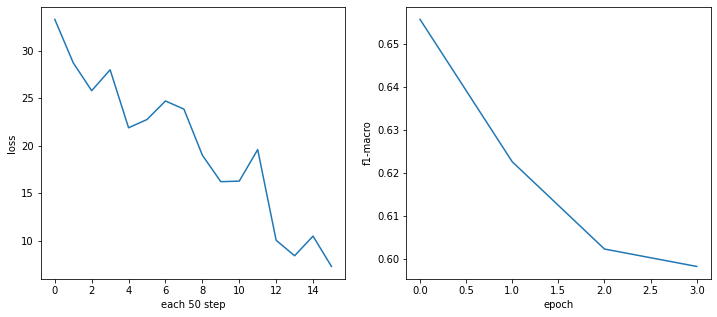

In [13]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(range(len(loss_collection)), loss_collection)
plt.xlabel(f'each {k} step')
plt.ylabel('loss')

plt.subplot(122)
plt.plot(range(len(eval_f1_macro)), eval_f1_macro)
plt.xlabel(f'epoch')
plt.ylabel('f1-macro')

## Tesing

In [14]:
# test dataloader
test_dataset = NewsDataloader(test_data, tokenizer)
batch_size = 11
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

with torch.no_grad():
  all_pred = []
  all_label = []
  for j, data in enumerate(test_dataloader):
    input_ids = data[0]["input_ids"].squeeze().to(device)
    attention_mask = data[0]["attention_mask"].squeeze().to(device)
    labels = data[1].to(device)
    feed_dict = {
        'input_ids': input_ids,
        'attention_mask': attention_mask
    }
    output = best_model(feed_dict)
    pred = output.argmax(dim=1, keepdim=True)
    all_label.extend(list(labels.cpu().numpy()))
    all_pred.extend(list(pred.view(-1).cpu().numpy()))


  f1_macro = f1_score(all_label, all_pred, average='macro')
  f1_micro = f1_score(all_label, all_pred, average='micro')
  accuracy = accuracy_score(all_label, all_pred)
  recall = recall_score(all_label, all_pred)
  roc_auc = roc_auc_score(all_label, all_pred)

  print(f'ROC-AUC {roc_auc}')
  print(f'F1-macro {f1_macro}')
  print(f'F1-micro {f1_micro}')
  print(f'Accuracy {accuracy}')
  print(f'Recall {recall}')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


ROC-AUC 0.6907115171650056
F1-macro 0.6682775391300054
F1-micro 0.8124174372523117
Accuracy 0.8124174372523117
Recall 0.5178571428571429


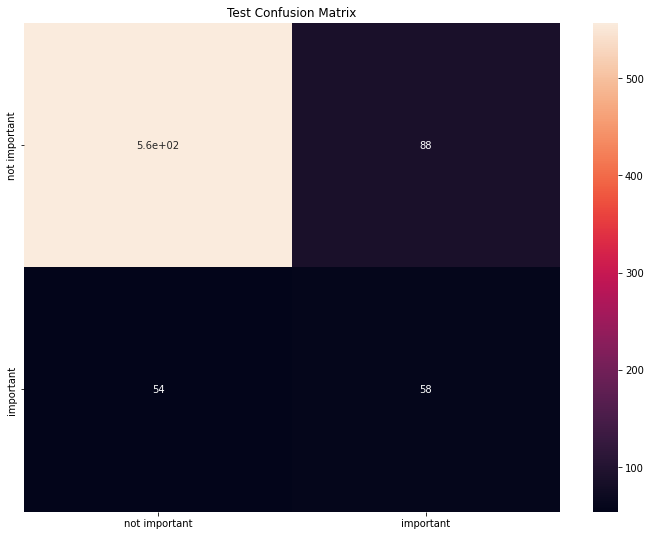

In [15]:
# confusion matrix for test data
classes = ['not important', 'important']
c_mat = confusion_matrix(all_label, all_pred)
df_cm = pd.DataFrame(c_mat, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (12,9))
plt.title('Test Confusion Matrix')
sn.heatmap(df_cm, annot=True)
plt.savefig('roberta_conf.jpg', dpi=400)

In [16]:
# save model
from google.colab import drive  
drive.mount('/content/drive')
torch.save(best_model, 'drive/MyDrive/project_roberta_final_category.pth')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load & Use Model

In [ ]:
! gdown --id 1_TnL_FYvbJWma0-RwdHM0tOdA7JMfO5Y
best_model = torch.load('project_roberta_final_category.pth')